### Image Classification Modelling on Trash Images

With the data having been nicely organized and processed, that means the data is ready for model building. In this stage, a deep learning classifier has to readjust itself each time images are captured to the input layer, then with forward and backward passes, the model's weights are constantly updated. Under the chain rule, each time the loss function yields the performance output, the optimizer (commonly stochastic gradient descent) takes account of the difference between ground truths and predictions that the model generates and the find the way to update weight coefficients that may bring the function closer to the minimum objective under the specified criteria. 

Our main purpose for this notebook is to establish a point where the deep learning obtains the capacity of recognizing distinctive patterns of the provided images, in this case a collection of trashes. To achieve that, a pre-trained model ResNet18 will be included and the model development will be conducted in PyTorch. Originally developed by Facebook (now Meta), PyTorch has long since earned highly reputations for solid basis of deep learning implementation in academics and industries. With rich and vast amount of libraries and modules, anyone seeking for adding strong predictive modellings for either empowering research or enhancing products with minimum barrier to thanks to dynamic computational graphs and mostly the "Pythonic" adoption on its development.

We go through detailed step-by-step of how the entire process is conducted.

In [1]:
# Import PyTorch Framework Libraries
import torch
from torch.utils.data import Dataset

# Import torchvision
import torchvision
from torchvision import transforms
from PIL import Image

In [2]:
## Importing External libraries
import numpy as np

# Import matplotlib for visualization
import matplotlib.pyplot as plt

In [3]:
# Importing built-in Python Libraries
import os
import sys
from pathlib import Path
import shutil
import glob

In [4]:
## Verify that the PyTorch can gain an access to CUDA device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.3.0+cu118
torchvision version: 0.18.0+cu118


Add a parent directory to the environment variable `PARENT_DIR` so that every data needs to be called in can easily be loaded from there. 

In [6]:
PARENT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
PARENT_DIR

'D:\\github_repos\\mlzoomcamp\\image_classification_trash'

## Image and Data Preparation

As we noticed, the images and labels were originally provided in a large dictionary from HuggingFace hub, and it took 4-6 minutes to load a whole data. That's a reason behind resizing and downloading them in separate folders. Now, images and labels are available in three sets along with folder classes, turning them into torch Dataset objects could not be much easier as previously done before. 

In [7]:
from torchvision.datasets import ImageFolder

In [8]:
train_Dataset = ImageFolder(
                    os.path.join(PARENT_DIR, 'data', 'processed', 'trash_images_train_resized'), 
                    transform=transforms.ToTensor(),
                    target_transform=None)


val_Dataset = ImageFolder(
                    os.path.join(PARENT_DIR, 'data', 'processed', 'trash_images_val_resized'),
                    transform=transforms.ToTensor(),
                    target_transform=None)


test_Dataset = ImageFolder(
                    os.path.join(PARENT_DIR, 'data', 'processed', 'trash_images_test_resized'),
                    transform=transforms.ToTensor(),
                    target_transform=None)

### Input and Output shape

Let's view what the first image looks like, in both shape and data type.

In [9]:
# What's the shape of the image?
image, label = train_Dataset[0]
print(f'Image shape of the first image is {image.shape}')
print(f'Image format is {type(image)}')

Image shape of the first image is torch.Size([3, 512, 384])
Image format is <class 'torch.Tensor'>


In [10]:
print(f'Label of the first image is {label}')
print(f'Label format is {type(label)}')

Label of the first image is 0
Label format is <class 'int'>


A good start for us. Both image and label are already in torch format. Checking on the dimension (shape) of the image and its order, it comes in RGB color as denoted in the first value of `[3, 512, 384]`. Meanwhile, the height and width is 512 and 384 pixel, respectively.

Try to verify if torch Dataset format of the train dataset is confirmed.

In [11]:
# Verify if train_Dataset is a Dataset object
assert isinstance(train_Dataset, torch.utils.data.Dataset)

Next, we see what are classes attached to `train_Dataset`.

In [12]:
# View classes
class_names = train_Dataset.classes
class_names

['cardboard', 'glass', 'metal', 'papers', 'plastics', 'trash']

In [13]:
# Create a dictionary mapping of clasees for labelling
class_map = dict(zip(list(range(0, len(class_names))), class_names))
class_map

{0: 'cardboard',
 1: 'glass',
 2: 'metal',
 3: 'papers',
 4: 'plastics',
 5: 'trash'}

Knowing that six different classes populated `train_Dataset`, it is taken the case as multiclass classification. As such, we will construct a model with its output layer specified to learn and predict those classes, leaving categorical cross entropy as a suitable choice for measuring performance.

#### Visualization

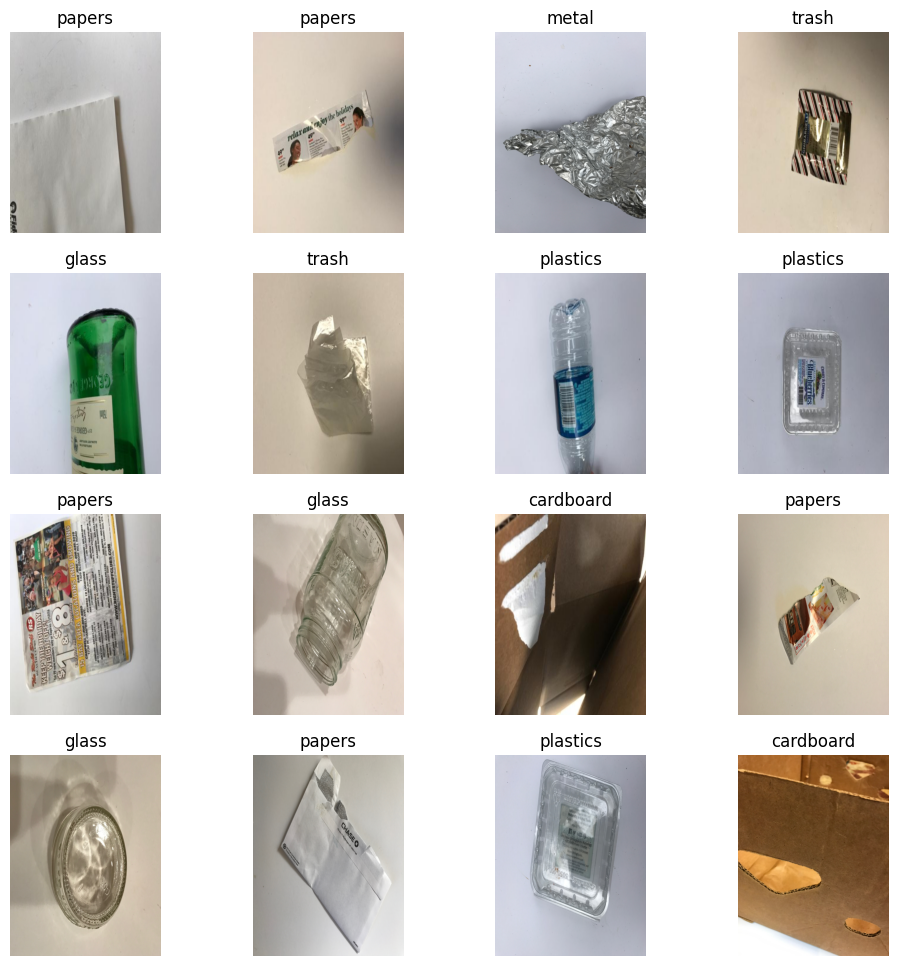

In [14]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(12, 12))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_Dataset), size=[1]).item()
    img, label = train_Dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze().permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis(False);

#### Transformation

To add variations of images per each set, we can apply `transforms` function to put together a few of image modification steps. Additionally, we also resize images to a smaller scale that ResNet18 can accept.

In [15]:
# Transformations for training set
train_transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor()])

val_transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor()])

test_transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor()])

In [16]:
train_Dataset.transform = train_transformer
val_Dataset.transform = val_transformer
test_Dataset.transform = test_transformer

In [17]:
# What's the shape of the image after passing through transformation steps?
image, label = train_Dataset[0]
print(f'Image shape of the first image is {image.shape}')
print(f'Image format is {type(image)}')

Image shape of the first image is torch.Size([3, 224, 224])
Image format is <class 'torch.Tensor'>


### DataLoader

`DataLoader` turn a large dataset into an iterable object with smaller chunks. Unless the computing resource is near infinite, we can hardly imagine deep Learning capable of updating parameters and weights a whole data all at once. It's much feasible to break data into chunks (many called **batches** or **mini batches**) and let gradient descent performs more. A golden standard for `batch_size`, 32 is a good number to begin for many problems. 

In [18]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_Dataset, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

val_dataloader = DataLoader(val_Dataset,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

test_dataloader = DataLoader(test_Dataset,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

In [19]:
# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, val_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of validation dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001A1715CD0F0>, <torch.utils.data.dataloader.DataLoader object at 0x000001A1715CDAE0>, <torch.utils.data.dataloader.DataLoader object at 0x000001A1715E2A40>)
Length of train dataloader: 110 batches of 32
Length of validation dataloader: 34 batches of 32
Length of test dataloader: 15 batches of 32


In [20]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Image size: torch.Size([3, 224, 224])
Label: 4, label size: torch.Size([])


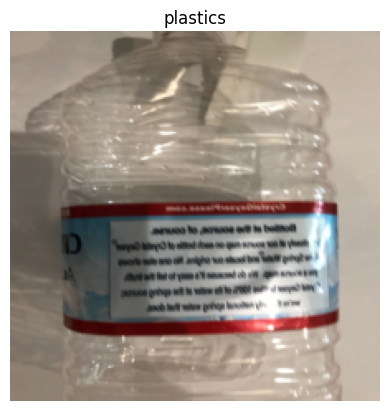

In [21]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze().permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("Off");

print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## Transfer Learning: ResNet18

A prexisting model will be used; `ResNet18` is one of the available preset models, having already been pretrained on a much larger dataset, thus we can potentially benefit from these pretrained weight for our classification problem using the trash dataset.

Before we dive in the practical sides of transfer learning, here explained a few thoughts. As we may notice, employing the newly designed deep learning to run through the data has to put more time to let its weights and parameters updated to better converge with data. Not to mention that the deeper neural networks made the more difficult they are to train. That meeans a large number of epochs has to be passed on the training process since it intially has no prior domain knowledge from data. Convnets from scratch also consumes vast amount of data before eventually reaching the generalization point.

That's where transfer learning comes in to mitigate these issues. In the past few years, researchers and engineers in AI field came with a few ideas of constantly feeding mpdels with large banks of images, most commonly MNIST, ImageNet, CIFAR. As such, deep learning models are now well-equipped with weights that carry "knowledge" of features gained from extensive data. The convolutional base refers to the previously trained networks to be placed by a new classifier on top. When ones try to implement these pre-trained models to learn from new use cases, a thing to do is modify a densely classifier layer before attaching this last layer to the convolutional base.

Let's put through transfer learning into practice. This time, `ResNet18` acts as the convolutional base to extract distinct features of six types of trash and train a new classifier based on ResNet outputs.

In [84]:
from torchvision import models
from torch import nn
from torch import optim

# ResNet18
weights = models.ResNet18_Weights.DEFAULT 
pretrained_resnet18 = models.resnet18(weights=weights)

num_ftrs = pretrained_resnet18.fc.in_features
pretrained_resnet18.fc = nn.Linear(num_ftrs, 6)

In [85]:
from torchinfo import summary

summary(pretrained_resnet18, input_size=[32, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 6]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

In [ ]:
# from torchviz import make_dot, make_dot_from_trace

# make_dot(pretrained_resnet18(train_features_batch), params=dict(pretrained_resnet18.named_parameters()))

#### Loss Function and Optimizer

Loss function is applied as a criteria that the model aims to optimize the specified metric. In this case, given six different classes that the model has to specify, categorical cross-entropy works for multiclass classification; `CrossEntropyLoss` computes logloss from input logits and return class probabilities for each available class.

In [87]:
from torch import nn
from torch import optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_resnet18.parameters(), lr=1e-4)

To keep track on how long it taks the during training, we can utilize timer from `timeit`.

In [88]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import default_timer from timeit
from timeit import default_timer as timer

For the concise training, we put together losses and accuracy of model trained on training set under a function. 

In [89]:
def train(model, num_epochs, train_dl, valid_dl):
    train_time_start_on_gpu = timer()
    
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    model.to(device)
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for x_batch, y_batch in train_dl:
            # Send data to GPU
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # 1. Forward pass
            pred = model(x_batch)

            # 2. Calculate loss
            loss = loss_fn(pred, y_batch)

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # 3. Optimizer zero grad
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                # Send data to GPU
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)
                
                loss = loss_fn(pred, y_batch)

                # Accumulate the loss and accuracy values per batch
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')

    train_time_end_on_gpu = timer()
    periods = train_time_end_on_gpu - train_time_start_on_gpu
    print(f"Train time on GPU: {periods:.4f} seconds")
    
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid



In [90]:
torch.manual_seed(42)
num_epochs = 7

hist = train(pretrained_resnet18, num_epochs, train_dataloader, val_dataloader)

 14%|█████████████████▋                                                                                                          | 1/7 [01:26<08:38, 86.37s/it]

Epoch 1 accuracy: 0.8043 val_accuracy: 0.8841


 29%|███████████████████████████████████▍                                                                                        | 2/7 [02:52<07:11, 86.37s/it]

Epoch 2 accuracy: 0.9349 val_accuracy: 0.9152


 43%|█████████████████████████████████████████████████████▏                                                                      | 3/7 [04:19<05:46, 86.60s/it]

Epoch 3 accuracy: 0.9709 val_accuracy: 0.9340


 57%|██████████████████████████████████████████████████████████████████████▊                                                     | 4/7 [05:45<04:19, 86.46s/it]

Epoch 4 accuracy: 0.9771 val_accuracy: 0.9425


 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                   | 5/7 [07:11<02:52, 86.26s/it]

Epoch 5 accuracy: 0.9806 val_accuracy: 0.9416


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 6/7 [08:38<01:26, 86.29s/it]

Epoch 6 accuracy: 0.9786 val_accuracy: 0.9444


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [10:04<00:00, 86.34s/it]

Epoch 7 accuracy: 0.9871 val_accuracy: 0.9538
Train time on GPU: 604.3909 seconds


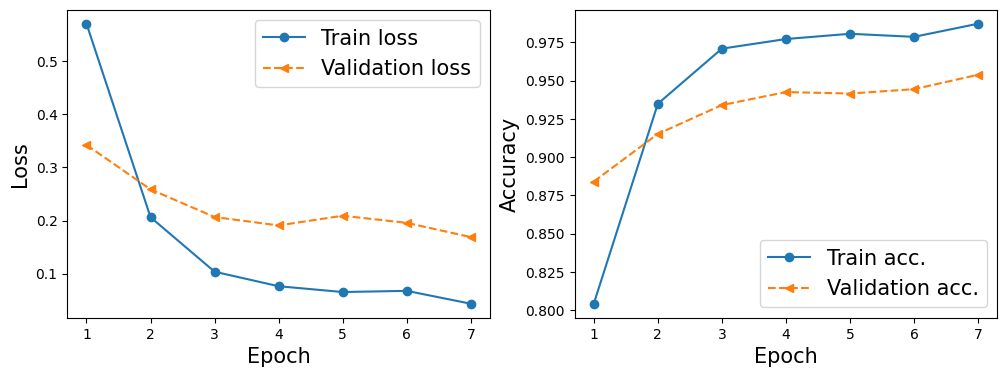

In [91]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

We can safely know that ResNet18 manages to achieve remarkable performance in short epochs. We will switch the model priority from training state to inference state to see how much the model is able to predict correctly on test sets.

In [80]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}



In [81]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [92]:
# Calculate model 1 results with device-agnostic code 
model_1_results = eval_model(model=pretrained_resnet18, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'ResNet', 'model_loss': 0.1687343269586563, 'model_acc': 95.0}

Now, let's try to predict some test samples with updated weight on ResNet.

In [93]:
import random

# Randomly choose 16 images and labels from test_Dataset
test_random_sample = random.sample(list(test_Dataset), k=16)

In [94]:
# View the first test sample shape and label
print(f"Test sample image shape: {test_random_sample[0][0].shape}")
print(f"Test sample label: {test_random_sample[0][1]} ({class_names[int(test_random_sample[0][1])]})")

Test sample image shape: torch.Size([3, 224, 224])
Test sample label: 3 (papers)


In [95]:
pred_probs = []

# Set the model to eval mode
pretrained_resnet18.eval()

# activate inference mode to begin comparison of the model's inference against chosen sample data
with torch.inference_mode():
    for image in test_random_sample:
        # Prepare sample
        sample = torch.unsqueeze(image[0], dim=0).to(device) # Add an extra dimension and send sample to device

        # Forward pass (model outputs raw logit)
        pred_logit = pretrained_resnet18(sample)

        # Get prediction probability (logit -> prediction probability)
        pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

        # Get pred_prob off GPU for further calculations
        pred_probs.append(pred_prob.cpu())

In [96]:
torch.stack(pred_probs)

tensor([[1.5811e-04, 1.7642e-05, 1.3509e-05, 9.2098e-01, 6.5587e-02, 1.3245e-02],
        [9.9980e-01, 1.1014e-05, 1.3522e-04, 5.9992e-06, 8.6429e-06, 3.4318e-05],
        [2.4094e-05, 2.0802e-06, 2.6985e-05, 9.9987e-01, 6.8726e-05, 1.2774e-05],
        [9.8369e-05, 1.1985e-02, 8.9273e-01, 7.7528e-02, 8.7744e-05, 1.7570e-02],
        [7.3342e-05, 3.6729e-03, 7.5477e-05, 5.4051e-05, 9.9577e-01, 3.5115e-04],
        [2.1984e-06, 1.1018e-05, 9.9983e-01, 1.5408e-04, 1.4913e-06, 5.3464e-06],
        [2.8178e-05, 2.0151e-05, 1.6201e-04, 4.0407e-01, 4.5623e-04, 5.9526e-01],
        [2.5801e-05, 5.6401e-05, 9.9985e-01, 6.2988e-05, 1.0270e-06, 2.3972e-06],
        [9.9815e-01, 1.5060e-04, 1.6191e-03, 1.7301e-06, 1.7748e-05, 5.6362e-05],
        [3.7287e-05, 2.7974e-03, 9.9693e-01, 5.6188e-06, 6.7759e-05, 1.5845e-04],
        [6.0930e-04, 3.8585e-02, 3.4793e-01, 4.1516e-02, 5.6204e-01, 9.3184e-03],
        [9.9981e-01, 3.3840e-06, 1.7982e-04, 5.4751e-07, 2.0812e-06, 3.3884e-06],
        [4.5621e

In [97]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = torch.stack(pred_probs).argmax(dim=1)
pred_classes

tensor([3, 0, 3, 2, 4, 2, 5, 2, 0, 2, 4, 0, 3, 5, 3, 3])

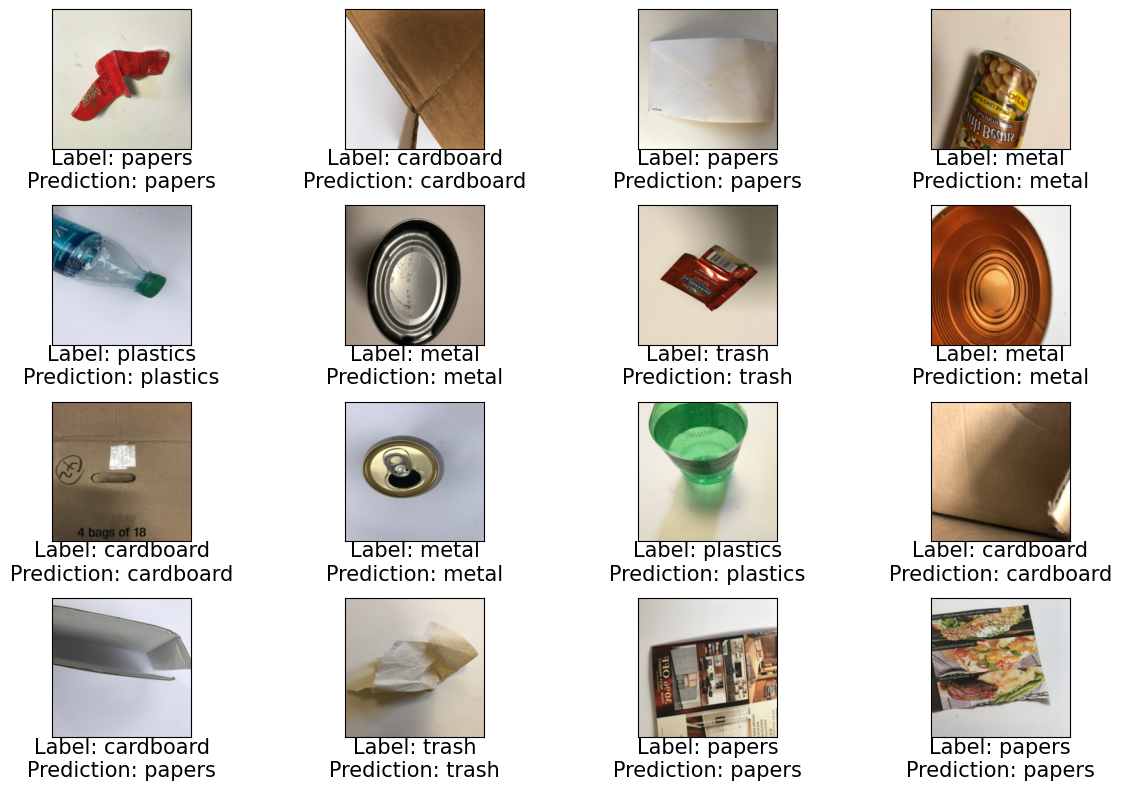

In [98]:
fig = plt.figure(figsize=(12, 8))

for i in range(len(test_random_sample)):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(test_random_sample[i][0].squeeze().permute(1, 2, 0))
    ax.text(0.5, -0.15, f'Label: {class_names[test_random_sample[i][1]]}\nPrediction: {class_names[pred_classes[i]]}', 
            size=15, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

### Confusion Matrix

In [87]:
from itertools import chain

def flatten_chain(matrix):
    return list(chain.from_iterable(matrix))

In [99]:
# Make predictions with trained model
y_preds = []

pretrained_resnet18.eval()
with torch.inference_mode():
    correct = 0
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = pretrained_resnet18(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
        # Compute accuracy and accumulate
        _, predicted = torch.max(y_logit.data, 1)
        correct += (predicted == y).sum().item()
        
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
        
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.62it/s]


In [103]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [94]:
y_pred_tensor.shape

torch.Size([461])

In [96]:
torch.tensor(test_Dataset.targets).shape

torch.Size([461])

In [104]:
y_pred_list = [int(x) for x in y_pred_tensor]

In [105]:
all_labels = []

for inputs, labels in test_dataloader:
    all_labels.extend(labels.cpu().numpy())

In [106]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, y_pred_list)

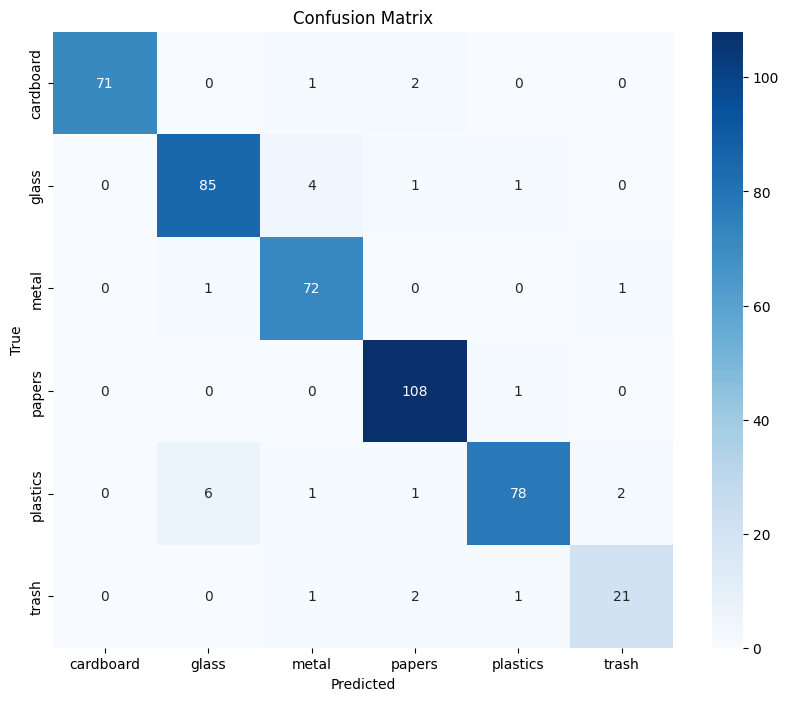

In [109]:
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_Dataset.classes, yticklabels=test_Dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Model Versioning and Tracking with Weights and Biases

In [35]:
# Log in to your W&B account
import wandb

wandb.login()

wandb: Currently logged in as: rizdi21. Use `wandb login --relogin` to force relogin


True

In [36]:
# # start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="image-classification-trash",

    # track hyperparameters and run metadata
    config={
        "epochs": 10,
        "batch_size": 32,
        "lr": 1e-4,
        }
)

In [37]:
# Copy your config 
config = wandb.config

#### Loss Function and Optimizer

Loss function is applied as a criteria that the model aims to optimize the specified metric. In this case, given six different classes that the model has to specify, categorical cross-entropy works for multiclass classification; `CrossEntropyLoss` computes logloss from input logits and return class probabilities for each available class.

In [56]:
from torch import nn
from torch import optim

# Make the loss and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_resnet18.parameters(), lr=config.lr)

To keep track on how long it taks the during training, we can utilize timer from `timeit`.

In [57]:
from timeit import default_timer as timer

In [58]:
import math

n_steps_per_epoch = math.ceil(len(train_dataloader.dataset) / config.batch_size)
n_steps_per_epoch

110

#### Scaling ResNet18 with CUDA Mixed Precisions


For the concise training, we put together losses and accuracy of model trained on training set under a function.

In [67]:
from torch.cuda.amp import GradScaler, autocast

# Use mixed precision training
scaler = GradScaler()

In [43]:
def log_image_table(images, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # 🐝 Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["image", "pred", "target"]+[f"score_{i}" for i in range(10)])
    for img, pred, targ, prob in zip(images.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

In [73]:
def train(model, num_epochs, train_dataloader, valid_dataloader):
    """
    Begin steps of training deep learning on the given DataLoader.

    Args:
        - model: a Deep learning model to be updated on weights
        - num_epochs: int
        - train_dataloader: train_dataloader
        - val_dataloader: val_dataloader

    Returns:
        - loss_hist_train: a list of loss values of training set
        - loss_hist_valid: a list of loss values of validation set
        - accuracy_hist_train: a list of accuracy values of training set
        - accuracy_hist_valid: a list of accuracy values of validation set

    """
    
    train_time_start_on_cpu = timer()
    
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    example_ct, step_ct = 0, 0
    model.to(device)
    for epoch in range(num_epochs):
        #########
        model.train()
        for step, (x_batch, y_batch) in enumerate(train_dataloader):
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                # Send data to GPU
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                # 1. Forward pass
                pred = model(x_batch)
        
                # 2. Calculate loss
                loss = loss_fn(pred, y_batch)
                
            # 4. Backward pass with mixed precision
            scaler.scale(loss).backward()

            # 5. Optimizer step
            scaler.step(optimizer)
            scaler.update()
                # # 4. Loss backward
                # loss.backward()
        
                # # 5. Optimizer step
                # optimizer.step()
        
            # 3. Optimizer zero grad
            optimizer.zero_grad()
    
            example_ct += len(x_batch)
            metrics = {"train/train_loss": loss, 
                           "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch, 
                           "train/example_ct": example_ct}
                
            if step + 1 < n_steps_per_epoch:
                # 🐝 Log train metrics to wandb 
                wandb.log(metrics)
                
            step_ct += 1
            
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()
    
        loss_hist_train[epoch] /= len(train_dataloader.dataset)
        accuracy_hist_train[epoch] /= len(train_dataloader.dataset)
        #########
        
        model.eval()
        with torch.no_grad():
            for i, (x_batch, y_batch) in enumerate(val_dataloader):
                # Send data to GPU
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
    
                # Compute accuracy and accumulate
                _, predicted = torch.max(pred.data, 1)
                
                # Log one batch of images to the dashboard, always same batch_idx.
                if i==0 and epoch==(config.epochs-1):
                    log_image_table(x_batch, predicted, y_batch, pred.softmax(dim=1))
                    
                # Accumulate the loss and accuracy values per batch
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()
    
        loss_hist_valid[epoch] /= len(val_dataloader.dataset)
        accuracy_hist_valid[epoch] /= len(val_dataloader.dataset)
    
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
        #########
    train_time_end_on_gpu = timer()
    periods = train_time_end_on_gpu - train_time_start_on_gpu
    print(f"Train time on GPU: {periods:.4f} seconds")
    
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid



In [74]:
### Set the seed for reproducibility
torch.manual_seed(42)

### Set number of epochs
num_epochs = 10

### Apply user-defined function 'train' to begin the training
hist = train(pretrained_resnet18, num_epochs, train_dataloader, val_dataloader)

# 🐝 Close your wandb run 
wandb.finish()

Epoch 1 accuracy: 0.9997 val_accuracy: 0.9453
Epoch 2 accuracy: 0.9354 val_accuracy: 0.9208
Epoch 3 accuracy: 0.9609 val_accuracy: 0.9453
Epoch 4 accuracy: 0.9783 val_accuracy: 0.9623
Epoch 5 accuracy: 0.9831 val_accuracy: 0.9321
Epoch 6 accuracy: 0.9863 val_accuracy: 0.9548
Epoch 7 accuracy: 0.9954 val_accuracy: 0.9661
Epoch 8 accuracy: 0.9891 val_accuracy: 0.9557
Epoch 9 accuracy: 0.9931 val_accuracy: 0.9736


ValueError: This table expects 13 columns: ['image', 'pred', 'target', 'score_0', 'score_1', 'score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9'], found 9

In [75]:
wandb.finish()

train/epoch,▁▁▁▁▁▂▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
train/example_ct,▁▁▁▁▁▂▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
train/train_loss,▄▃▃█▃▃▂▁▁▁▁▁▁▂▂▁▁▁▂▂▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁
train/epoch,9.99091
train/example_ct,34988
train/train_loss,3.44431


In [340]:
train_time_start_on_cpu = timer()

loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs

example_ct = 0
step_ct = 0

for epoch in range(num_epochs):
    model_resnet18.train()
    for step, (x_batch, y_batch) in enumerate(train_dataloader):
        # Send data to GPU
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # 1. Forward pass
        pred = model_resnet18(x_batch)

        # 2. Calculate loss
        loss = loss_fn(pred, y_batch)

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        example_ct += len(x_batch)
        metrics = {"train/train_loss": loss, 
                       "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch, 
                       "train/example_ct": example_ct}
            
        if step + 1 < n_steps_per_epoch:
            # 🐝 Log train metrics to wandb 
            wandb.log(metrics)
                
        step_ct += 1
        
        loss_hist_train[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.sum().cpu()

    loss_hist_train[epoch] /= len(train_dataloader.dataset)
    accuracy_hist_train[epoch] /= len(train_dataloader.dataset)
    
    model_resnet18.eval()
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(val_dataloader):
            # Send data to GPU
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model_resnet18(x_batch)
            loss = loss_fn(pred, y_batch)

            # Compute accuracy and accumulate
            _, predicted = torch.max(pred.data, 1)
            correct += (predicted == y_batch).sum().item()
            
            # Log one batch of images to the dashboard, always same batch_idx.
            if i==0 and epoch==(config.epochs-1):
                log_image_table(x_batch, predicted, y_batch, pred.softmax(dim=1))
                
            # Accumulate the loss and accuracy values per batch
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
            loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
            accuracy_hist_valid[epoch] += is_correct.sum().cpu()

    loss_hist_valid[epoch] /= len(val_dataloader.dataset)
    accuracy_hist_valid[epoch] /= len(val_dataloader.dataset)

    print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')

train_time_end_on_gpu = timer()
periods = train_time_end_on_gpu - train_time_start_on_gpu
print(f"Train time on GPU: {periods:.4f} seconds")


# 🐝 Close your wandb run 
wandb.finish()

Epoch 1 accuracy: 0.9666 val_accuracy: 0.9350
Epoch 2 accuracy: 0.9711 val_accuracy: 0.9369
Epoch 3 accuracy: 0.9837 val_accuracy: 0.9510
Epoch 4 accuracy: 0.9891 val_accuracy: 0.9425
Train time on GPU: 17641.4098 seconds


train/epoch,▁▁▂▂▂▂▃▁▁▂▂▂▂▃▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train/example_ct,▁▁▂▂▂▂▃▁▁▂▂▂▂▃▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train/train_loss,█▄▄▄▄▃▂▂▂▂▂▁▂▃▁▁▁▁▂▁▂▁▁▁▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂
train/epoch,3.99091
train/example_ct,13988
train/train_loss,2.60467


### Save the Model

In [117]:
# Create target directory
target_dir_path = Path(os.path.join(PARENT_DIR, "models" , "ResNet18"))
target_dir_path.mkdir(parents=True,
                    exist_ok=True)

In [118]:
model_name = "model_resnet_checkpoint.pth"

# Create model save path
assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
model_save_path = target_dir_path / model_name



In [119]:
# Save the model state_dict()
print(f"[INFO] Saving model to: {model_save_path}")
torch.save(obj=pretrained_resnet18.state_dict(),
         f=model_save_path)

[INFO] Saving model to: D:\github_repos\mlzoomcamp\image_classification_trash\models\ResNet18\model_resnet_checkpoint.pth
